# Sequential Low Rank Regression

<a target="_blank" href="https://colab.research.google.com/github/nikhil-chigali/Sequential-Low-Rank-Regression/blob/main/sequential_low_rank_regression.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [135]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds, eigs
from pprint import pprint

from utils.args import GDArgs

seed = 42
np.random.seed(seed)

## Step 0: Initialization

In [154]:
# Dimension of the matrix W (W = AB^T)
d = 100
m = 50
n = 500  # Number of samples
r = 10  # Rank of the matrix W


# Generating n input data points with d features with a normal distribution
X = np.random.randn(n, d)

# Normalizing the rows of X
X = X / la.norm(X, axis=1, keepdims=True)

# Generating Sigma, the diagonal matrix
S_star = np.geomspace(100, 1, num=r)
S_star_sqrt = np.diag(np.sqrt(S_star))

# Generating M
M = np.random.randn(d, m)
[U_star, temp, V_star] = la.svd(M)  # Performing SVD on M

# Generating A^* and B^*
A_star_hat = U_star[:, :r]  # Top-r left singular vectors
B_star_hat = V_star[:r, :].T  # Top-r right singular vectors

# Generating A* and B*
A_star = A_star_hat @ S_star_sqrt
B_star = B_star_hat @ S_star_sqrt
W_star = A_star @ B_star.T
# W_star = W_star / la.norm(W_star, 'fro')

# Noise
std = 5e-1
Z = np.random.randn(n, m)
Z = std * (1 / la.norm(Z, 'fro')) * Z

# Generating Y
Y = X @ W_star + Z

# Calculating the Lipschitz constant of H (Spectral Norm)
H = X.T @ X
[u, s, v] = svds(H, k=1)
L = s[0] # Spectral norm of H

# Setting learning rate eta
eta = 1/L

# Setting the arguments
args = GDArgs(
    d=d,
    m=m,
    n=n,
    r=r,
    eta=eta,
)

pprint(args)

GDArgs(d=100,
       r=10,
       m=50,
       n=500,
       eta=np.float64(0.09497996574500964),
       eta_A=1e-05,
       eta_B=1e-05,
       iters=1000,
       tau=20,
       epsilon=1e-08,
       lambda_orth=0.7)


In [155]:
U_star.shape, temp.shape, V_star.shape

((100, 100), (50,), (50, 50))

## Step 1.1: Implementing Simple Gradient Descent

In [156]:
def GD(X, Y, W_star, args: GDArgs):
    W_old = np.random.randn(args.d, args.m)
    i = 1

    rel_errors = []
    while i <= args.iters:
        grad = X.T @ (X @ W_old - Y)

        # print(la.matrix_rank(grad))

        W_new = W_old - args.eta * grad

        # Calculate the relative error
        rel_error = la.norm(W_new - W_star, "fro") / la.norm(W_star, "fro")
        rel_errors.append(rel_error)

        # check if the relative error between W and W* is smaller than epsilon
        if rel_error <= args.epsilon:
            print("Tolerance Error reached. Stopping the algorithm.")
            break

        W_old = W_new
        i += 1
    return W_new, rel_errors


# W_star and r are not used in the function yet

Rank of W: 50


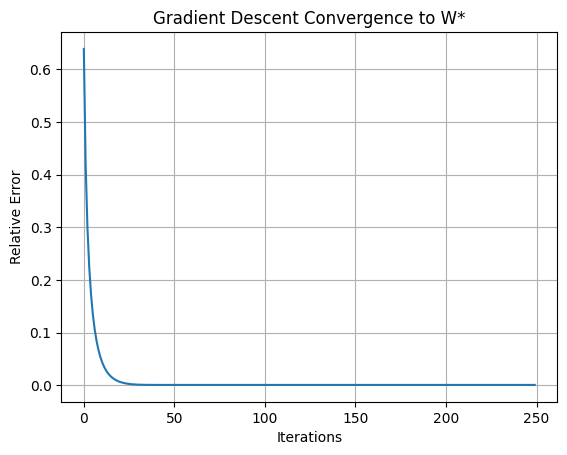

In [157]:
# Sanity check for the GD function

args.iters = 250

W, rel_errors = GD(X, Y, W_star, args)
print(f"Rank of W: {la.matrix_rank(W)}")

# Plotting the relative error
plt.plot(rel_errors)
plt.xlabel('Iterations')
plt.ylabel('Relative Error')
plt.title('Gradient Descent Convergence to W*')
plt.grid()
plt.show()


## Step 1.2: Implementing Iterative Hard-Thresholding [Projected Gradient Descent]

In [158]:
def IHT(X, Y, W_star, args: GDArgs):

    W_old = np.random.randn(args.d, args.m)
    rel_errors = []
    i = 1
    while i <= args.iters:
        grad = X.T @ (X @ W_old - Y)

        # print(la.matrix_rank(grad))

        W_mid = W_old - args.eta * grad

        # Projecting W_new to become r-rank
        U, S, V = la.svd(W_mid)
        W_new = U[:, : args.r] @ np.diag(S[: args.r]) @ V[: args.r, :]

        # Compute the relative error
        rel_error = la.norm(W_new - W_star, ord="fro") / la.norm(W_star, ord="fro")
        rel_errors.append(rel_error)

        # check if the error between W and W* is smaller than the epsilon
        if rel_error <= args.epsilon:
            print("Tolerance Error reached. Stopping the algorithm.")
            break

        W_old = W_new
        i += 1
    return W_new, rel_errors


# W_star is not used in the function yet

Rank of W_IHT: 10


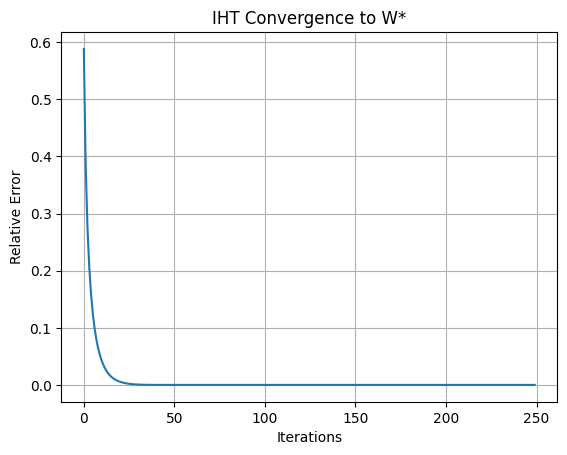

In [159]:
# Sanity check for the IHT function
W_IHT, rel_errors = IHT(X, Y, W_star, args)

print(f"Rank of W_IHT: {la.matrix_rank(W_IHT)}")

# Plotting the relative error
plt.plot(rel_errors)
plt.xlabel('Iterations')
plt.ylabel('Relative Error')
plt.title('IHT Convergence to W*')
plt.grid()
plt.show()

In [160]:
print(f"Distance between W and W_star: {la.norm(W - W_star, ord='fro')}")
print(f"Distance between W_IHT and W_star: {la.norm(W_IHT - W_star, ord='fro')}\n")

print(f"Relative Error of W: {la.norm(W - W_star, ord='fro') / la.norm(W_star, ord='fro')}")
print(f"Relative Error of W_IHT: {la.norm(W_IHT - W_star, ord='fro') / la.norm(W_star, ord='fro')}\n")

Distance between W and W_star: 0.11179628908523262
Distance between W_IHT and W_star: 0.0583148671431372

Relative Error of W: 0.0008948185433696067
Relative Error of W_IHT: 0.00046675274198083275



### Step 1.2.1: Comparing rank-1 IHT approximations of `W*` with that of the actual `W*`  

In [161]:
# Initializing iters and epsilon

args_seq = GDArgs(
        d=d,
        m=m,
        n=n,
        r=1,
        eta=eta, 
        iters=1000, 
        epsilon=1e-16
    )

W_r1_components = np.zeros((args.r, d, m))

Y_res = Y.copy()

# Computing the SVD of W_star
U, S, V = la.svd(W_star, full_matrices=False)
print(f"Left Singular Matrix `U`: {U.shape}")
print(f"Singular Values `S`: {S.shape}")
print(f"Right Singular Matrix `V`: {V.shape}\n")

# Initializing the sum of the r-rank components
W_IHT_sum = np.zeros_like(W_star)
W_SVD_sum = np.zeros_like(W_star)

# Relative error between the IHT and SVD components
rank = 10
rel_error_IHT_SVD = np.zeros(rank)

for i in range(rank):
    ## IHT + Deflation
    # IHT
    W_IHT, errors = IHT(X, Y_res, W_star, args_seq)
    # Storing the r-rank components
    W_r1_components[i] = W_IHT

    # Adding the r-rank component to the sum
    W_IHT_sum += W_IHT

    # Deflation
    Y_res = Y_res - X @ W_IHT

    ## SVD
    W_SVD = S[i] * np.outer(U[:, i], V[i, :])

    # Adding the r-rank component to the sum
    W_SVD_sum += W_SVD

    # Computing the relative error between the IHT and SVD components
    rel_error_IHT_SVD[i] = la.norm(W_IHT - W_SVD, ord="fro") / la.norm(W_SVD, ord="fro")
    print(
        f"Rank {i+1:02d} - Sigma_{i+1:02d}: {S[i]:.05f} | Relative Error (IHT, SVD): {rel_error_IHT_SVD[i]}"
    )

# Rank-r cumulative error
print(
    "Relative error (W_IHT_sum, W_SVD_sum): ",
    la.norm(W_IHT_sum - W_SVD_sum, ord="fro") / la.norm(W_SVD_sum, ord="fro"),
)

Left Singular Matrix `U`: (100, 50)
Singular Values `S`: (50,)
Right Singular Matrix `V`: (50, 50)

Rank 01 - Sigma_01: 100.00000 | Relative Error (IHT, SVD): 0.02484004777758953
Rank 02 - Sigma_02: 59.94843 | Relative Error (IHT, SVD): 0.03989310082320918
Rank 03 - Sigma_03: 35.93814 | Relative Error (IHT, SVD): 0.14119024656036522
Rank 04 - Sigma_04: 21.54435 | Relative Error (IHT, SVD): 0.23088420748717564
Rank 05 - Sigma_05: 12.91550 | Relative Error (IHT, SVD): 0.06058653446983271
Rank 06 - Sigma_06: 7.74264 | Relative Error (IHT, SVD): 0.08797748891218925
Rank 07 - Sigma_07: 4.64159 | Relative Error (IHT, SVD): 0.13925369836319967
Rank 08 - Sigma_08: 2.78256 | Relative Error (IHT, SVD): 0.09252888359420124
Rank 09 - Sigma_09: 1.66810 | Relative Error (IHT, SVD): 0.16916968259105558
Rank 10 - Sigma_10: 1.00000 | Relative Error (IHT, SVD): 0.11541297635517694
Relative error (W_IHT_sum, W_SVD_sum):  0.00046675274198107865


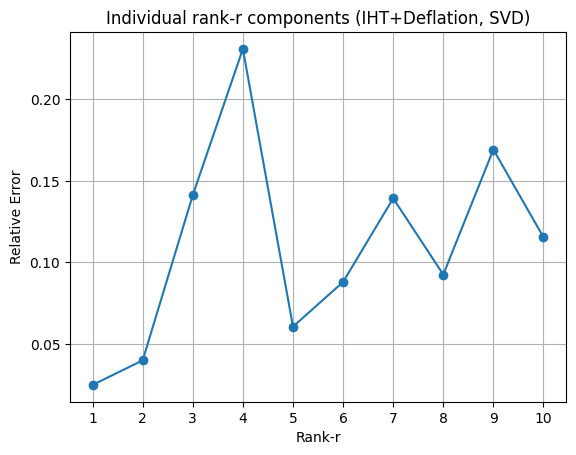

In [162]:
# Plotting the relative error between the IHT and SVD components
plt.plot(range(1, rank+1), rel_error_IHT_SVD, marker='o')
plt.xticks(range(1, rank+1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error")
plt.title("Individual rank-r components (IHT+Deflation, SVD)")
plt.grid()
plt.show()


Rank 01 - Relative Error: 0.5998059205520019
Rank 02 - Relative Error: 0.35954450254901127
Rank 03 - Relative Error: 0.21607000105330568
Rank 04 - Relative Error: 0.12930929302064054
Rank 05 - Relative Error: 0.07764054731666492
Rank 06 - Relative Error: 0.04629144278304898
Rank 07 - Relative Error: 0.0273319558919271
Rank 08 - Relative Error: 0.015656892362831396
Rank 09 - Relative Error: 0.00805286148241625
Rank 10 - Relative Error: 0.0004661822942505727


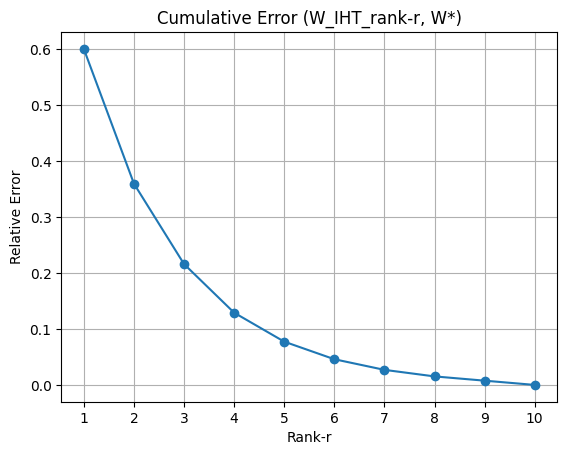

In [15]:
# Cumulative error of rank-r approximation using IHT+Deflation method
W_r_errors = np.zeros(rank)

for i in range(rank):
    W_r = np.sum(W_r1_components[:i+1], axis=0)
    W_r_errors[i] = la.norm(W_r - W_star, ord='fro') / la.norm(W_star, ord='fro')
    print(f"Rank {i+1:02d} - Relative Error: {W_r_errors[i]}")
    
# Plotting the Cumulative error of rank-r approximation
plt.plot(range(1, rank+1), W_r_errors, marker='o')
plt.xticks(range(1, rank+1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error")
plt.title("Cumulative Error (W_IHT_rank-r, W*)")
plt.grid()

plt.show()

Rank 01 - Relative Error: 0.02484004777758953
Rank 02 - Relative Error: 0.025384105432923684
Rank 03 - Relative Error: 0.041613176705083486
Rank 04 - Relative Error: 0.00950276929757363
Rank 05 - Relative Error: 0.007860170796135572
Rank 06 - Relative Error: 0.005879004098909652
Rank 07 - Relative Error: 0.0029360813123406296
Rank 08 - Relative Error: 0.002445084090614844
Rank 09 - Relative Error: 0.001021512706048213
Rank 10 - Relative Error: 0.00046675274198107865


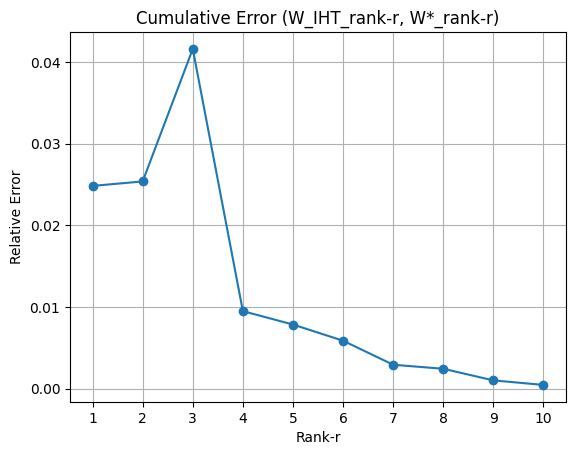

In [163]:
# Cumulative error of rank-r approximation using IHT+Deflation method
W_r_errors = np.zeros(rank)

for i in range(rank):
    W_r = np.sum(W_r1_components[:i+1], axis=0)
    W_star_i = np.sum([S[j] * np.outer(U[:, j], V[j, :]) for j in range(i+1)], axis=0)
    W_r_errors[i] = la.norm(W_r - W_star_i, ord='fro') / la.norm(W_star_i, ord='fro')
    print(f"Rank {i+1:02d} - Relative Error: {W_r_errors[i]}")
    
# Plotting the Cumulative error of rank-r approximation
plt.plot(range(1, rank+1), W_r_errors, marker='o')
plt.xticks(range(1, rank+1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error")
plt.title("Cumulative Error (W_IHT_rank-r, W*_rank-r)")
plt.grid()

plt.show()

## Step 2.1: Implementing Factorized GD

In [164]:
def FactorizedGD(X, Y, W_star, args: GDArgs):
    # Initialization of A and B
    A_new = np.random.randn(args.d, args.r)
    B_new = np.random.randn(args.m, args.r)

    rel_errors = {"A": [], "B": []}

    i = 1
    while i <= args.iters:
        A_old = A_new
        B_old = B_new

        # Compute the gradient of A and B
        grad_A = X.T @ (X @ (A_old @ B_old.T) - Y) @ B_old
        grad_B = (X.T @ (X @ (A_old @ B_old.T) - Y)).T @ A_old

        # Update A and B
        A_new = A_old - args.eta * grad_A
        B_new = B_old - args.eta * grad_B

        # Compute the error
        error_A = la.norm(A_new - A_star, ord="fro") / la.norm(A_star, ord="fro")
        error_B = la.norm(B_new - B_star, ord="fro") / la.norm(B_star, ord="fro")

        # Relative error between the (A, B) and (A*, B*) components
        rel_errors["A"].append(error_A)
        rel_errors["B"].append(error_B)

        # check if the relative error in A, B and A*, B* is smaller than epsilon
        if error_A <= args.epsilon and error_B <= args.epsilon:
            print("Convergence reached. Stopping the algorithm.")
            break

        i += 1

    return A_new, B_new, rel_errors

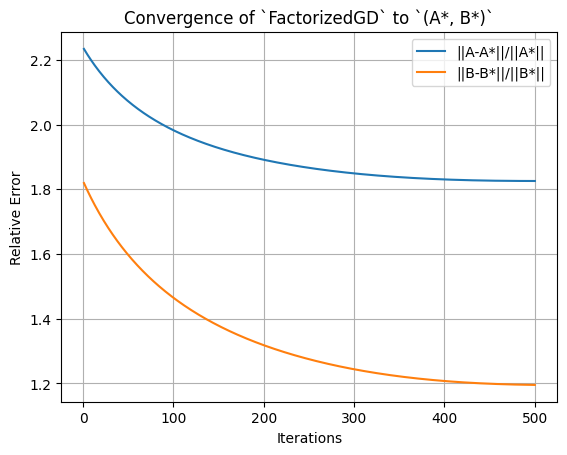

Relative Error of A:  1.825642260465386
Relative Error of B:  1.19533220732562


In [169]:
args.r = 10
args.eta = 1e-5
args.iters = 500
args.epsilon = 1e-8

A_new, B_new, rel_errors = FactorizedGD(X, Y, W_star, args)

# Plotting the relative error between the (A, B) and (A*, B*) components
plt.plot(range(1, args.iters+1), rel_errors["A"], label="||A-A*||/||A*||")
plt.plot(range(1, args.iters+1), rel_errors["B"], label="||B-B*||/||B*||")
plt.xlabel("Iterations")
plt.ylabel("Relative Error")
plt.title("Convergence of `FactorizedGD` to `(A*, B*)`")
plt.legend()
plt.grid()
plt.show()

print("Relative Error of A: ", rel_errors["A"][-1])
print("Relative Error of B: ", rel_errors["B"][-1])

## Step 2.2: Factorized GD with Orthogonality Constraint

### Step 2.2.1: GD with a weighted Orthogonality regularizer
We will optimize for the new objective function with a weighted orthogonality regularizer. The intention is to have `A` & `B` as orthogonal matrices.

**Loss function**
> $\mathbb{L} = \frac{1}{2} \|Y - AB \cdot X\|_{F}^{2}$

**Orthogonality Loss** 
> $\mathbb{O}_A = \frac{1}{2} \| A^TA - I \odot A^TA \|_F^2$ \
> $\mathbb{O}_B = \frac{1}{2} \| B^TB - I \odot B^TB \|_F^2$ \
> Where, $A \odot B$ represents the Hadamard Product between `A` and `B`

Note that the Orthogonality constraint is not dependant on the data `X`, `Y`. We will run an additional GD update loop with the Orthogonality loss's gradient $\tau$ times every iteration.

In [177]:
from utils.initializations import random_AB, orthonormal_AB
from utils.visualize import plot_all_errors

In [178]:
# Defining Loss and Gradients for Factorized GD

def MSE_loss_factorized(X, Y, A, B, grad=False):
    # Depends on the data X and Y
    if grad:
        grad_A = X.T @ (X @ (A @ B.T) - Y) @ B
        grad_B = (X @ (A @ B.T) - Y).T @ X @ A
        
        # Normalizing the gradients
        # grad_A = grad_A / la.norm(grad_A, ord="fro")
        # grad_B = grad_B / la.norm(grad_B, ord="fro")
        
        return grad_A, grad_B
    return 0.5 * la.norm(Y - X @ (A @ B.T), ord="fro") ** 2


def Orthogonal_loss_factorized(A, B, grad=False):
    # Doesn't depend on the data X and Y
    gram_A = A.T @ A
    gram_B = B.T @ B
    if grad:
        grad_A = 2 * A @ (gram_A - np.eye(gram_A.shape[0]) * gram_A)
        grad_B = 2 * B @ (gram_B - np.eye(gram_B.shape[0]) * gram_B)
        
        # Normalizing the gradients
        # grad_A = grad_A / la.norm(grad_A, ord="fro")
        # grad_B = grad_B / la.norm(grad_B, ord="fro")
        
        return grad_A, grad_B
    orth_A = 0.5 * la.norm(gram_A - np.eye(gram_A.shape[0]) * gram_A, ord="fro") ** 2
    orth_B = 0.5 * la.norm(gram_B - np.eye(gram_B.shape[0]) * gram_B, ord="fro") ** 2
    return orth_A, orth_B

In [179]:
print("MSE Loss (A_star, B_star): ", MSE_loss_factorized(X, Y, A_star, B_star))
print("Orthogonal Constraint Loss (A_star, B_star): ", Orthogonal_loss_factorized(A_star, B_star))

MSE Loss (A_star, B_star):  0.12499999999999997
Orthogonal Constraint Loss (A_star, B_star):  (np.float64(2.101133627132198e-27), np.float64(2.6305404257778033e-27))


In [180]:
A, B = random_AB(args)

print("MSE Loss (A, B): ", MSE_loss_factorized(X, Y, A, B))
print("Orthogonal Constraint Loss (A, B): ", Orthogonal_loss_factorized(A, B))

MSE Loss (A, B):  40113.73482537363
Orthogonal Constraint Loss (A, B):  (np.float64(0.5194236057589203), np.float64(0.8590739227906088))


In [181]:
def MSE_GD_Update(X, Y, A_old, B_old, eta_A, eta_B):
    """
    Update the factorized matrices A and B using the gradient descent update rule
    """
    grad_A, grad_B = MSE_loss_factorized(X, Y, A_old, B_old, grad=True)
    A_new = A_old - eta_A * grad_A
    B_new = B_old - eta_B * grad_B
    return A_new, B_new

def Orth_GD_Update(A_old, B_old, eta_A, eta_B):
    """
    Update the factorized matrices A and B using the gradient descent update rule
    """
    grad_A_orth, grad_B_orth = Orthogonal_loss_factorized(A_old, B_old, grad=True)
    A_new = A_old - eta_A * grad_A_orth
    B_new = B_old - eta_B * grad_B_orth
    return A_new, B_new

def FactorizedGD_Orth(X, Y, init_AB, W_star, args: GDArgs):
    
    # Initialization of A and B
    A_new, B_new = init_AB(args)

    # Error and relative error
    errors = {"orth_A": [], "orth_B": [], "MSE": []}
    rel_errors = {"A": [], "B": []}

    i = 1
    while i <= args.iters:
        A_old = A_new
        B_old = B_new

        # MSE update on A and B
        A_new, B_new = MSE_GD_Update(X, Y, A_old, B_old, args.eta_A, args.eta_B)

        # Orthogonal update on A and B
        for t in range(args.tau):
            A_new, B_new = Orth_GD_Update(A_new, B_new, args.eta_A, args.eta_B)

        # Compute the error
        orth_A, orth_B = Orthogonal_loss_factorized(A_new, B_new)
        mse = MSE_loss_factorized(X, Y, A_new, B_new)

        # Relative error between the (A, B) and (A*, B*) components
        errors["orth_A"].append(orth_A)
        errors["orth_B"].append(orth_B)
        errors["MSE"].append(mse)

        # Compute relative errors
        error_A = la.norm(A_new - A_star, ord="fro") / la.norm(A_star, ord="fro")
        error_B = la.norm(B_new - B_star, ord="fro") / la.norm(B_star, ord="fro")

        # Relative error between the (A, B) and (A*, B*) components
        rel_errors["A"].append(error_A)
        rel_errors["B"].append(error_B)

        # check if the relative error in A, B and A*, B* is smaller than epsilon
        if error_A <= args.epsilon and error_B <= args.epsilon:
            print("Convergence reached. Stopping the algorithm.")
            break

        i += 1

    return A_new, B_new, rel_errors, errors

In [182]:
## Testing convergence of FactorizedGD_Orth_1
# Random initialization of A, B
# Rank r = 10
# Learning rates, eta_A, eta_B = 1e-5, 1e-5
# Orthogonilization steps per iteration `tau` = 0

args = GDArgs(iters=500, epsilon=1e-8, r=10)
args.tau = 0
args.eta_A, args.eta_B = 1e-5, 1e-5

A_new, B_new, rel_errors, errors = FactorizedGD_Orth(X, Y, random_AB, W_star, args)


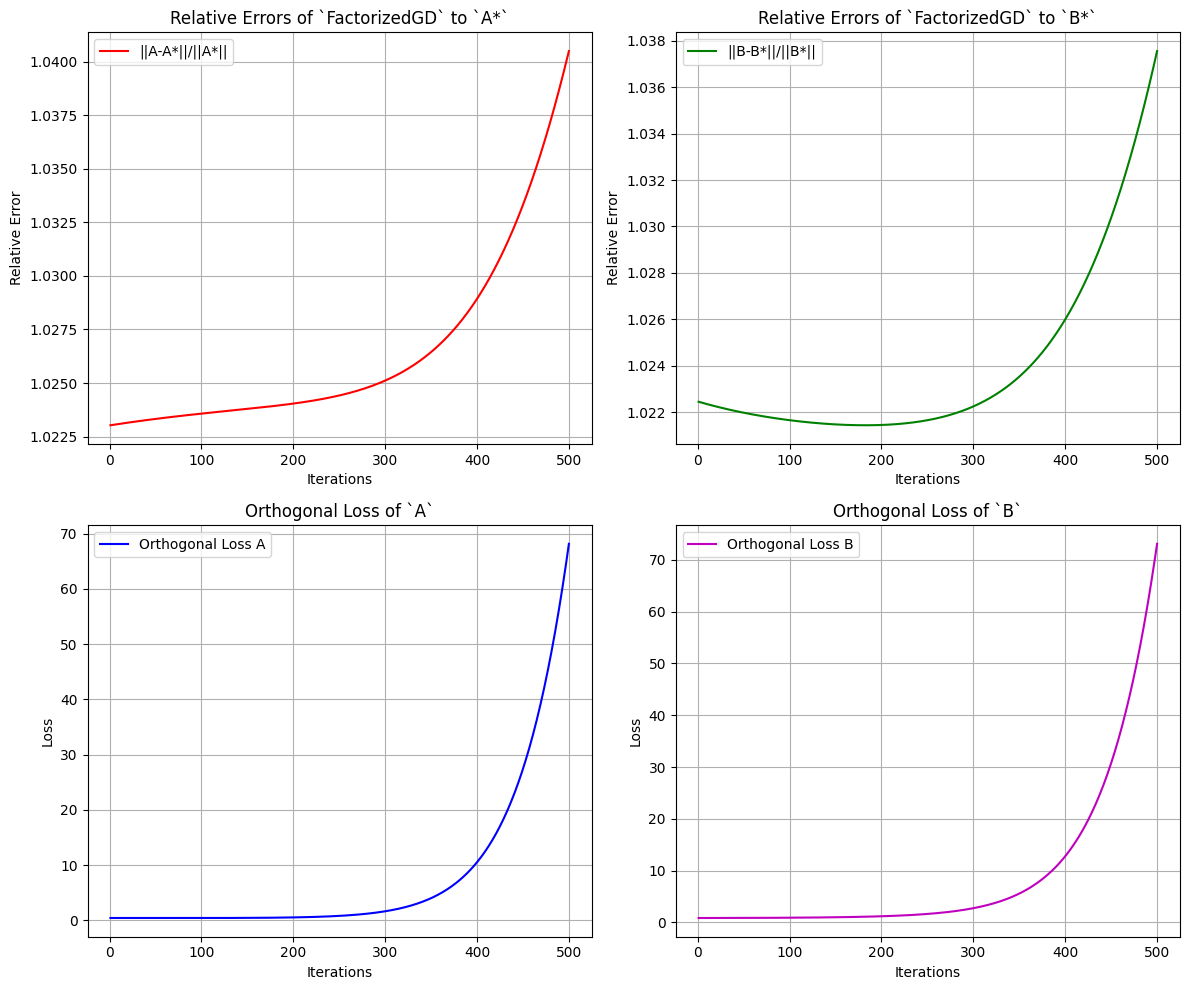

In [183]:
plot_all_errors(rel_errors, errors)

In [73]:
Q, R = la.qr(W_star)
print("Q @ Q^T: \n", np.round(Q @ Q.T))

print("==================================================================")

mag = la.norm(W_star, ord=2, axis=0, keepdims=True)**2 / W_star.shape[0]
Q_ = Q * mag
print("Q_ @ Q_^T: \n", np.round(Q_ @ Q_.T))

Q @ Q^T: 
 [[ 1.  0. -0. ...  0. -0. -0.]
 [ 0.  1.  0. ... -0.  0.  0.]
 [-0.  0.  1. ...  0. -0. -0.]
 ...
 [ 0. -0.  0. ...  0.  0. -0.]
 [-0.  0. -0. ...  0.  1. -0.]
 [-0.  0. -0. ... -0. -0.  1.]]
Q_ @ Q_^T: 
 [[11.  3. -1. ...  0.  0.  0.]
 [ 3. 13.  4. ...  1.  1. -1.]
 [-1.  4.  9. ...  0. -6. -2.]
 ...
 [ 0.  1.  0. ...  6.  5. -2.]
 [ 0.  1. -6. ...  5. 56.  3.]
 [ 0. -1. -2. ... -2.  3.  7.]]
